In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
DATA_DIR = '/g/data/w40/ab2313/rainfall_2020/mjo_index'

In [3]:
os.listdir(DATA_DIR)

['mjo_daily_clim_1981_2010_1979-2022_detrended.nc',
 'mjo_monthly_anoms_clim_1981_2010_1979-2022.nc',
 'rmm.74toRealtime.txt',
 'mjo_monthly_clim_1981_2010_1979-2022_detrended.nc',
 'mjo_daily_clim_1981_2010_1979-2022.nc',
 '.ipynb_checkpoints',
 'mjo_monthly_anoms_clim_1981_2010_1979-2022_detrended.nc',
 'mjo_monthly_clim_1981_2010_1979-2022.nc']

In [4]:
rmm_raw_ds = xr.open_dataset(os.path.join(DATA_DIR, 'mjo_daily_clim_1981_2010_1979-2022.nc')); rmm_raw_ds

<xarray.Dataset>
Dimensions:    (time: 16040)
Coordinates:
    dayofyear  (time) int64 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-11-30
Data variables:
    phase      (time) float64 ...
    amplitude  (time) float64 ...
    phase_ID   (time) int64 ...

In [5]:
mean = rmm_raw_ds.amplitude.mean().values
std = rmm_raw_ds.amplitude.std().values
bound = mean-std
bound

217801725.39620945

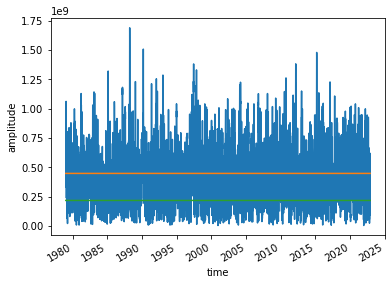

In [6]:
rmm_raw_ds.amplitude.plot()
plt.plot(rmm_raw_ds.time.values, np.tile(mean, len(rmm_raw_ds.time.values)))
plt.plot(rmm_raw_ds.time.values, np.tile(bound, len(rmm_raw_ds.time.values)))


In [7]:
rmm1_raw_ds = rmm_raw_ds.amplitude * np.cos(rmm_raw_ds.phase); rmm2_raw_ds = rmm_raw_ds.amplitude * np.sin(rmm_raw_ds.phase)
rmm_ds = xr.concat([rmm1_raw_ds, rmm2_raw_ds], pd.Index(['rmm1', 'rmm2'], name='phase'));
scale = 1e9
rmm_ds = rmm_ds/scale
rmm_ds

<xarray.DataArray (phase: 2, time: 16040)>
array([[ 0.28587855,  0.35172672,  0.48093881, ...,  0.21113334,
         0.0454748 , -0.08453035],
       [-0.45152318, -0.25803697, -0.24738515, ...,  0.10850095,
         0.21004417,  0.22728505]])
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 327 328 329 330 331 332 333 334
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-11-30
  * phase      (phase) object 'rmm1' 'rmm2'

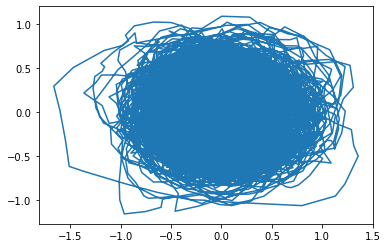

In [9]:
itime = 50
plt.plot(rmm_ds.sel(phase='rmm1').values, rmm_ds.sel(phase='rmm2').values)

In [10]:
interp_time = pd.date_range(start=rmm_ds.time.values[0], end=rmm_ds.time.values[-1], periods=len(rmm_ds.time.values)*2)
rmm_ds_interp = rmm_ds.interp(time=interp_time, method='quadratic')

In [11]:
# rmm_lismore_ds = rmm_ds.sel(time=limsmore_extended_slice)

In [12]:
def add_rmm_features(fig, ax):
    lim = 1.5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    # ax.grid(linestyle=":")
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

    ax.plot([-lim,lim],[-lim,lim], color='.8', ls='--', alpha=.5)
    ax.plot([lim, -lim],[-lim,lim], color='.8', ls='--', alpha=.5)
    ax.axhline(0, color='.8', ls='--', alpha=.5)
    ax.axvline(0, color='.8', ls='--', alpha=.5)
    circ = plt.Circle((0, 0), radius=bound/scale, edgecolor='0.8', facecolor='w', zorder=2)
    ax.add_patch(circ)
    ax.set_ylabel('PC1', fontsize=18.)
    ax.set_xlabel('PC2', fontsize=18.)

    shift = .15
    'Indian\nOcean'
    phases = ((-lim-shift, -1, '5'), (-1, -lim-shift, '6'), (1, -lim-shift, '7'), (lim+shift, -1, '8'),
             (-lim-shift,  1, '4'), (-1,  lim+shift, '3'), (1,  lim+shift, '2'), (lim+shift,  1, '1'))
    # phases = ((-lim-shift, -1, '1'), (-1, -lim-shift, '2'), (1, -lim-shift, '3'), (lim+shift, -1, '4'),
    #               (-lim-shift,  1, '8'), (-1,  lim+shift, '7'), (1,  lim+shift, '6'), (lim+shift,  1, '5'))
    for p in phases: ax.text(*p, fontsize=18., va='center_baseline', ha='center')
    # 
    ax.text(lim-shift, 0, 'West. Hem\nand Africa', fontsize=18, ha='center', va='center', rotation=-90)
    ax.text(-lim+shift, 0, 'Maritime\nContinent' , fontsize=18, ha='center', va='center', rotation=90)
    ax.text(0, lim-shift,'Indian\nOcean', fontsize=18, ha='center', va='center')
    ax.text(0, -lim+shift,'Western\nPacific', fontsize=18, ha='center', va='center')

In [13]:
def plot_all_flood_details(ax, ds, slice_1, slice_2=None, color='red', nday_extend=8):
    
    if slice_2 is None:
        slice_2 = slice(
            ds.sel(time=slice_1).time.values[0] - pd.to_timedelta(f'{nday_extend}D'),
            ds.sel(time=slice_1).time.values[0] + pd.to_timedelta(f'{nday_extend}D'))
    
    interp_time = pd.date_range(start=ds.sel(time=slice_2).time.values[0], end=ds.sel(time=slice_2).time.values[-1],
                                periods=len(ds.sel(time=slice_2).time.values)*2)
    ds_interp = ds.sel(time=slice_2).interp(time=interp_time, method='quadratic')
    
    start = 'Feb-' + str(ds_interp.sel(time=slice_2).time.dt.day.values[0])
    end = 'March-' + str(ds_interp.sel(time=slice_2).time.dt.day.values[-1])
    first_flood = 'Feb-' + str(ds.sel(time=slice_1).time.dt.day.values[0])
    end_flood = 'March-' + str(ds.sel(time=slice_1).time.dt.day.values[-1])
    print(f'{start=} {end=} {first_flood=}, {end_flood=}')
    
    # Plot the full dataset with interploated data
    ax.plot(ds_interp.sel(phase='rmm1').values, ds_interp.sel(phase='rmm2').values,
            color=color, linewidth=2.5, linestyle='--', alpha=.2)
    ax.scatter(ds.sel(phase='rmm1', time=slice_2).values, ds.sel(phase='rmm2', time=slice_2).values, facecolor=color, s=50, alpha=.2)

    ax.plot(ds_interp.sel(phase='rmm1', time=slice_1).values, ds_interp.sel(phase='rmm2', time=slice_1).values,
            color=color, linewidth=3, label='Lismore Flood')
    ax.scatter(ds.sel(phase='rmm1', time=slice_1).values, ds.sel(phase='rmm2', time=slice_1).values, 
               facecolor=color, s=60, zorder=5)

#     ax.annotate(start, xy=(ds_interp.sel(time=slice_2, phase='rmm1').values[0], ds_interp.sel(time=slice_2, phase='rmm2').values[0]+.05),
#                 color=color, size=12.5);

#     ax.annotate(end, xy=(ds_interp.sel(time=slice_2,phase='rmm1').values[-1], ds_interp.sel(time=slice_2,phase='rmm2').values[-1]+.05),
                # color=color, size=12.5);
    ax.annotate(first_flood, xy=((ds_interp.sel(time=slice_1, phase='rmm1').values[0]-.12,
                                  ds_interp.sel(time=slice_1, phase='rmm2').values[0]-.1)),
                color=color, size=12.5)

    ax.annotate(end_flood, xy=((ds_interp.sel(time=slice_1, phase='rmm1').values[-1]-.12,
                                ds_interp.sel(time=slice_1, phase='rmm1').values[-1]+.1)),
                color=color, size=12.5)
    
    ax.legend(fontsize=15, loc='lower left')

    ax.annotate('1e9', xy=(0.01, 1.01), xycoords='axes fraction')
    ax.annotate('1e9', xy=(1.01, .01), xycoords='axes fraction')


In [14]:
# Februaruary-March
lismore_slice = slice('2022-02-24T00:00:00.000000000', '2022-03-01T00:00:00.000000000')
limsmore_extended_slice = slice('2022-02-14T00:00:00.000000000', '2022-03-10T00:00:00.000000000')

# Februaru March
sydney_slice = slice('2022-03-02T00:00:00.000000000', '2022-03-08T00:00:00.000000000')
sydney_extended_slice = slice('2022-02-26T00:00:00.000000000', '2022-03-16T00:00:00.000000000')

# July
sydney_slice2 = slice('2022-07-02T00:00:00.000000000', '2022-07-06T00:00:00.000000000')
sydney_extended_slice2 = slice('2022-06-26T00:00:00.000000000', '2022-07-14T00:00:00.000000000')

# October
mdb_nsw_slice = slice('2022-10-05T00:00:00.000000000', '2022-10-09T00:00:00.000000000')
mdb_vic_slice = slice('2022-10-13T00:00:00.000000000', '2022-10-14T00:00:00.000000000')
# Potentail small influence
mdb_north_slice = slice('2022-10-19T00:00:00.000000000', '2022-10-25T00:00:00.000000000')


start='Feb-5' end='March-21' first_flood='Feb-13', end_flood='March-14'


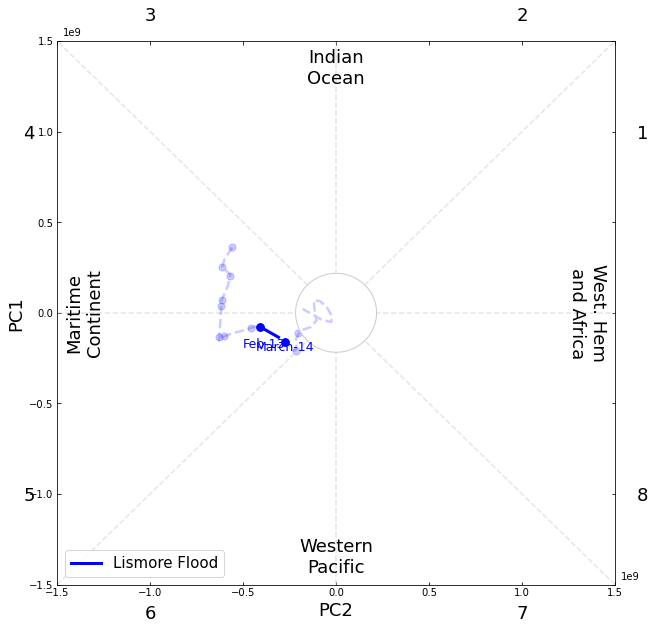

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

add_rmm_features(fig, ax)

# plot_all_flood_details(ax, rmm_ds, lismore_slice, limsmore_extended_slice)
# plot_all_flood_details(ax, rmm_ds, sydney_slice, sydney_extended_slice, color='blue')
# plot_all_flood_details(ax, rmm_ds, sydney_slice2, sydney_extended_slice2, color='blue')
plot_all_flood_details(ax, rmm_ds, mdb_vic_slice, color='blue')

In [17]:
# fig, ax = plt.subplots(figsize=(10,10))

# add_rmm_features(fig, ax)


# ax.plot(rmm_ds_interp.sel(phase='rmm1', time=limsmore_extended_slice).values,
#         rmm_ds_interp.sel(phase='rmm2', time=limsmore_extended_slice).values, color='red',
#         linewidth=2.5, linestyle='--', alpha=.2)
# ax.scatter(rmm_ds_interp.sel(phase='rmm1').values, rmm_ds_interp.sel(phase='rmm2').values, facecolor='red', s=50, alpha=.2)

# ax.plot(rmm_ds_interp.sel(phase='rmm1').sel(time=lismore_slice).values,
#         rmm_lismore_ds_interp.sel(phase='rmm2').sel(time=lismore_slice).values,
#         color='red', linewidth=3, label='Lismore Flood')
# ax.scatter(rmm_lismore_ds.sel(phase='rmm1').sel(time=lismore_slice).values, rmm_lismore_ds.sel(phase='rmm2').sel(time=lismore_slice).values, 
#            facecolor='red', s=60, zorder=5)

# ax.annotate(start, xy=(rmm_lismore_ds_interp.sel(phase='rmm1').values[0], rmm_lismore_ds_interp.sel(phase='rmm2').values[0]+.05),
#             color='red', size=12.5);

# ax.annotate(end, xy=(rmm_lismore_ds_interp.sel(phase='rmm1').values[-1], rmm_lismore_ds_interp.sel(phase='rmm2').values[-1]+.05),
#             color='red', size=12.5);
# ax.annotate(first_flood, xy=((rmm_ds_interp.sel(phase='rmm1', time=lismore_slice).values[0]-.12,
#                               rmm_ds_interp.sel(phase='rmm2', time=lismore_slice).values[0]-.1)),
#             color='red', size=12.5)

# ax.annotate(end_flood, xy=((rmm_ds_interp.sel(time=lismore_slice, phase='rmm1').values[-1]-.12,
#                             rmm_ds_interp.sel(time=lismore_slice, phase='rmm1').values[-1]+.1)),
#             color='red', size=12.5)

# ax.legend(fontsize=15, loc='lower left')

# ax.annotate('1e9', xy=(0.01, 1.01), xycoords='axes fraction')
# ax.annotate('1e9', xy=(1.01, .01), xycoords='axes fraction')